In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

In [3]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Drop columns with too many missing values
train = train.drop(columns=["Alley", "PoolQC", "Fence", "MiscFeature"])
test = test.drop(columns=["Alley", "PoolQC", "Fence", "MiscFeature"])

In [5]:
num_cols = train.select_dtypes(include=["int64", "float64"]).columns
for col in num_cols:
    if train[col].isnull().sum() > 0:
        train[col] = train[col].fillna(train[col].median())
    if col in test.columns and test[col].isnull().sum() > 0:
        test[col] = test[col].fillna(test[col].median())

In [6]:
cat_cols = train.select_dtypes(include=["object"]).columns
for col in cat_cols:
    if train[col].isnull().sum() > 0:
        train[col] = train[col].fillna(train[col].mode()[0])
    if col in test.columns and test[col].isnull().sum() > 0:
        test[col] = test[col].fillna(test[col].mode()[0])

In [7]:
# Total square footage
train["TotalSF"] = train["TotalBsmtSF"] + train["1stFlrSF"] + train["2ndFlrSF"]
test["TotalSF"] = test["TotalBsmtSF"] + test["1stFlrSF"] + test["2ndFlrSF"]

In [8]:
train["TotalBathrooms"] = train["FullBath"] + 0.5 * train["HalfBath"] + train["BsmtFullBath"] + 0.5 * train["BsmtHalfBath"]
test["TotalBathrooms"] = test["FullBath"] + 0.5 * test["HalfBath"] + test["BsmtFullBath"] + 0.5 * test["BsmtHalfBath"]

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
combined = pd.concat([train.drop("SalePrice", axis=1), test], sort=False)
cat_cols = combined.select_dtypes(include=["object"]).columns

In [11]:
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col])
    label_encoders[col] = le

In [12]:
X = combined.iloc[:train.shape[0], :]
X_test = combined.iloc[train.shape[0]:, :]
y = train["SalePrice"]

In [13]:
X = X.copy()
X["SalePrice"] = y
corr = X.corr()
top_features = corr["SalePrice"].abs().sort_values(ascending=False).head(15).index
X = X[top_features].drop("SalePrice", axis=1)
X_test = X_test[top_features.drop("SalePrice")]

In [14]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [17]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_valid_scaled)

In [18]:
ridge = Ridge(alpha=10)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_valid_scaled)

In [19]:
for model, preds in zip(["Linear Regression", "Ridge"], [y_pred_lr, y_pred_ridge]):
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    r2 = r2_score(y_valid, preds)
    print(f"{model} → RMSE: {rmse:.2f}, R²: {r2:.2f}")

Linear Regression → RMSE: 36974.20, R²: 0.82
Ridge → RMSE: 37015.42, R²: 0.82


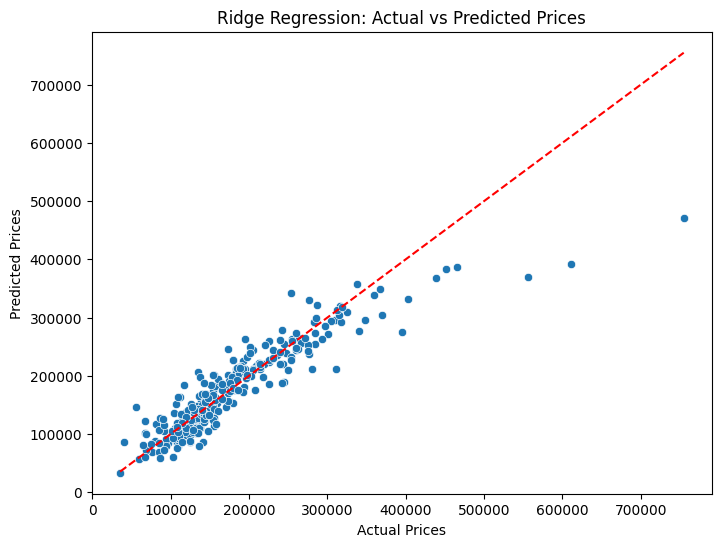

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_valid, y=y_pred_ridge)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Ridge Regression: Actual vs Predicted Prices")
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], '--r')
plt.show()

In [21]:
final_preds = ridge.predict(X_test_scaled)
submission = pd.DataFrame({"Id": test["Id"], "SalePrice": final_preds})
submission.to_csv("submission.csv", index=False)
print("Submission file created!")

Submission file created!
